In [16]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Configure Logger

In [18]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch 
import numpy as np 
from keypoint_detection.src.keypoint_utils import gaussian_heatmap, generate_keypoints_heatmap, get_keypoints_from_heatmap
from keypoint_detection import KeypointDetector
from keypoint_detection import BoxKeypointsDataModule, BoxKeypointsDataset


In [19]:

wandb_logger = WandbLogger(project="test-project", entity="airo-box-manipulation")

In [20]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [21]:
torch.cuda.is_available()

False

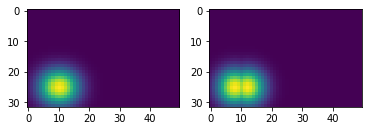

In [22]:
## Demonstration on why one should use max(.) instead of sum to combine the keypoints
# sum wil make 1 blob of 2 neighbouring keypoints
# furthermore it will also reduce the 
img = gaussian_heatmap((32,50),(8,25),torch.Tensor([4]))
img2 = gaussian_heatmap((32,50),(12,25),torch.Tensor([4]))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img  +img2)
axarr[1].imshow(torch.max(img, img2))

In [23]:
IMAGE_DATASET_PATH = "/workspaces/box-manipulation/datasets/box_dataset2"
JSON_PATH = "/workspaces/box-manipulation/datasets/box_dataset2/dataset.json"

In [24]:
def imshow(img):
    """
    plot Tensor as image
    images are kept in the [0,1] range, although in theory [-1,1] should be used to whiten..
    """
    np_img = img.numpy()
    # bring (C,W,H) to (W,H,C) dims
    img = np.transpose(np_img, (1,2,0))
    plt.imshow(img)
    plt.show()


In [25]:
def show_heatmap_overlay(img, heatmap):
    """
    plot Tensors of heatmap and image on same figure 
    """
    fig, ax = plt.subplots()  #create figure and axes
    img = img.numpy()
    img = np.transpose(img, (1,2,0))
    ax.imshow(img, alpha= 0.9)
    ax.imshow(heatmap.numpy(), alpha = 0.2)
    plt.show()

In [26]:


module = BoxKeypointsDataModule(BoxKeypointsDataset(JSON_PATH, IMAGE_DATASET_PATH),2)
batch = next(iter(module.train_dataloader()))
#print(batch)
print(batch[0].shape)
print(batch[1].shape)

torch.Size([2, 3, 256, 256])
torch.Size([2, 4, 2])


torch.Size([1, 2, 180, 180])
KeypointDetector(
  (validation_metric): KeypointmAPMetric()
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(4, 4))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(8, 8))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(16, 16))
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Conv2d(32, 32

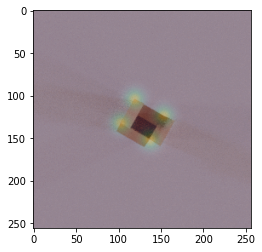

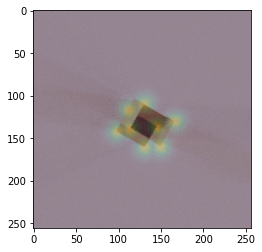

In [27]:
model = KeypointDetector(heatmap_sigma= 8)
dummy_input = torch.rand((1,3,180,180))

output = model(dummy_input)
print(output.shape)
print(model)

module = BoxKeypointsDataModule(BoxKeypointsDataset(JSON_PATH, IMAGE_DATASET_PATH),2)
batch = next(iter(module.train_dataloader()))
imgs, corner_keypoints, flap_keypoints = batch 
print(imgs[0].shape[1:])
print(imgs.shape)

heatmaps = model.create_heatmap_batch(imgs[0].shape[1:],corner_keypoints)
flap_heatmaps = model.create_heatmap_batch(imgs[0].shape[1:], flap_keypoints)
print(heatmaps.shape)
show_heatmap_overlay(imgs[0],heatmaps[0])
show_heatmap_overlay(imgs[0],flap_heatmaps[0])

In [28]:
pl.seed_everything(2021, workers = True) # deterministic run
model = KeypointDetector(detect_flap_keypoints=False)
module = BoxKeypointsDataModule(BoxKeypointsDataset(JSON_PATH, IMAGE_DATASET_PATH),2)
print(len(module.val_dataloader()))
print(len(module.train_dataloader()))
trainer = pl.Trainer(max_epochs = 1, logger=wandb_logger, gpus=0)


Global seed set to 2021
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


13
113


In [29]:
trainer.fit(model, module)

/opt/conda/envs/python39/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(

  | Name              | Type              | Params
--------------------------------------------------------
0 | validation_metric | KeypointmAPMetric | 0     
1 | model             | Sequential        | 102 K 
--------------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.412     Total estimated model params size (MB)
/opt/conda/envs/python39/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /workspaces/box-manipulation/keypoint-detection/notebooks/test-project/35zwigx7/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint di

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 2021


corner_ap=0.0031446540880503146


Training: 0it [00:00, ?it/s]

/opt/conda/envs/python39/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


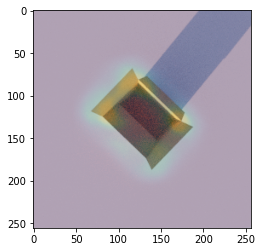

In [15]:
batch = next(iter(module.train_dataloader()))

imgs, corner_keypoints, flap_keypoints = batch 

with torch.no_grad():
    predictions = model(imgs)
    show_heatmap_overlay(imgs[0],predictions[0][0])

In [1]:
import wandb 
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Retry attempt failed:
Traceback (most recent call last):
  File "/opt/conda/envs/python39/lib/python3.9/site-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/opt/conda/envs/python39/lib/python3.9/site-packages/urllib3/util/connection.py", line 73, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/opt/conda/envs/python39/lib/python3.9/socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/python39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_respon

Problem at: /tmp/ipykernel_83930/2951088653.py 2 <module>


Process wandb_internal:
Traceback (most recent call last):
  File "/opt/conda/envs/python39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/envs/python39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/python39/lib/python3.9/site-packages/wandb/sdk/internal/internal.py", line 153, in wandb_internal
    thread.join()
  File "/opt/conda/envs/python39/lib/python3.9/threading.py", line 1053, in join
    self._wait_for_tstate_lock()
  File "/opt/conda/envs/python39/lib/python3.9/threading.py", line 1069, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt


KeyboardInterrupt: 

In [3]:
!ping 8.8.8.8

/bin/bash: ping: command not found
